In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import matplotlib.dates as mdates
import numpy as np
import glob
import datetime
import pytz
%matplotlib inline
n = 20
colors = plt.cm.turbo(np.linspace(0,1,n))
from datetime import timedelta
import xarray as xr
import metpy.calc as calc
from metpy.units import units
style = "/Users/cneumaie/OneDrive - Colostate/Styles/christine-paperlight.mpstyle"
import datetime
plt.style.use(style)
import matplotlib
matplotlib.rc('xtick', labelsize=32) 
matplotlib.rc('ytick', labelsize=32) 

Duplicate key in file '/Users/cneumaie/OneDrive - Colostate/Styles/christine-paperlight.mpstyle', line 15 ("xtick.color: 'k'")
Duplicate key in file '/Users/cneumaie/OneDrive - Colostate/Styles/christine-paperlight.mpstyle', line 16 ("ytick.color: 'k'")
Duplicate key in file '/Users/cneumaie/OneDrive - Colostate/Styles/christine-paperlight.mpstyle', line 27 ('axes.edgecolor:222222')


In [2]:
def get_times(FilePath):
    '''Converts surface station time data to datetime format and returns a pandas
    dataframe'''
    
    sfc_file = xr.open_dataset(glob.glob(FilePath+'BACS1_QC*.nc')[0])
    sfc_file
    df = sfc_file.to_dataframe()
    
    date_init = datetime.datetime(2022,1,1)   ##file is in format of seconds since Jan 1 2022
    ###Now we will convert the time to datetime function using a for loop
    datetime_list = []
    for i in range(len(sfc_file.time.values)):
        datetime_list.append(date_init+timedelta(minutes=int(sfc_file['time'][i].values))+timedelta(hours=6))###convert to UTC
    df['datetime'] = datetime_list
    ds = df.set_index('datetime') ###change the index to the datetime variable
    
    return ds

In [3]:
###load surface station data
sfc_filePath = '/Users/cneumaie/Downloads/'
sfc_df = get_times(sfc_filePath)

In [80]:
### Select case to show and add units
case_name  = 'IOP 03'
iop_sfc = sfc_df.where(sfc_df.iop==3).dropna()
press = (iop_sfc.pressure.values)*units.hPa
temp = (iop_sfc.temperature.values)*units.degC
rh = (iop_sfc.rh.values)/100
temp_K = (iop_sfc.temperature.values + 273.15)*units.K

In [81]:
iop_sfc["local"] = iop_sfc.index - datetime.timedelta(hours = 6)
iop_sfc = iop_sfc.set_index(["local"])

In [82]:
### Calculate mixing ratio
mixing_ratio = calc.mixing_ratio_from_relative_humidity(press, temp_K, rh)
### Calculate virtual potential temperature
iop_sfc['T_v'] = calc.virtual_temperature(temp_K, mixing_ratio)
iop_sfc['T_vC'] = iop_sfc.T_v.values - 273.15

In [94]:
### fill in missing times with Nans
times = np.arange(datetime.datetime(2022,5,29, 0), datetime.datetime(2022,5,29, 23,59), datetime.timedelta(minutes=1)).astype(datetime.datetime)
new_index = pd.Index(times, name = "local")
iop_sfc = iop_sfc.reindex(new_index)

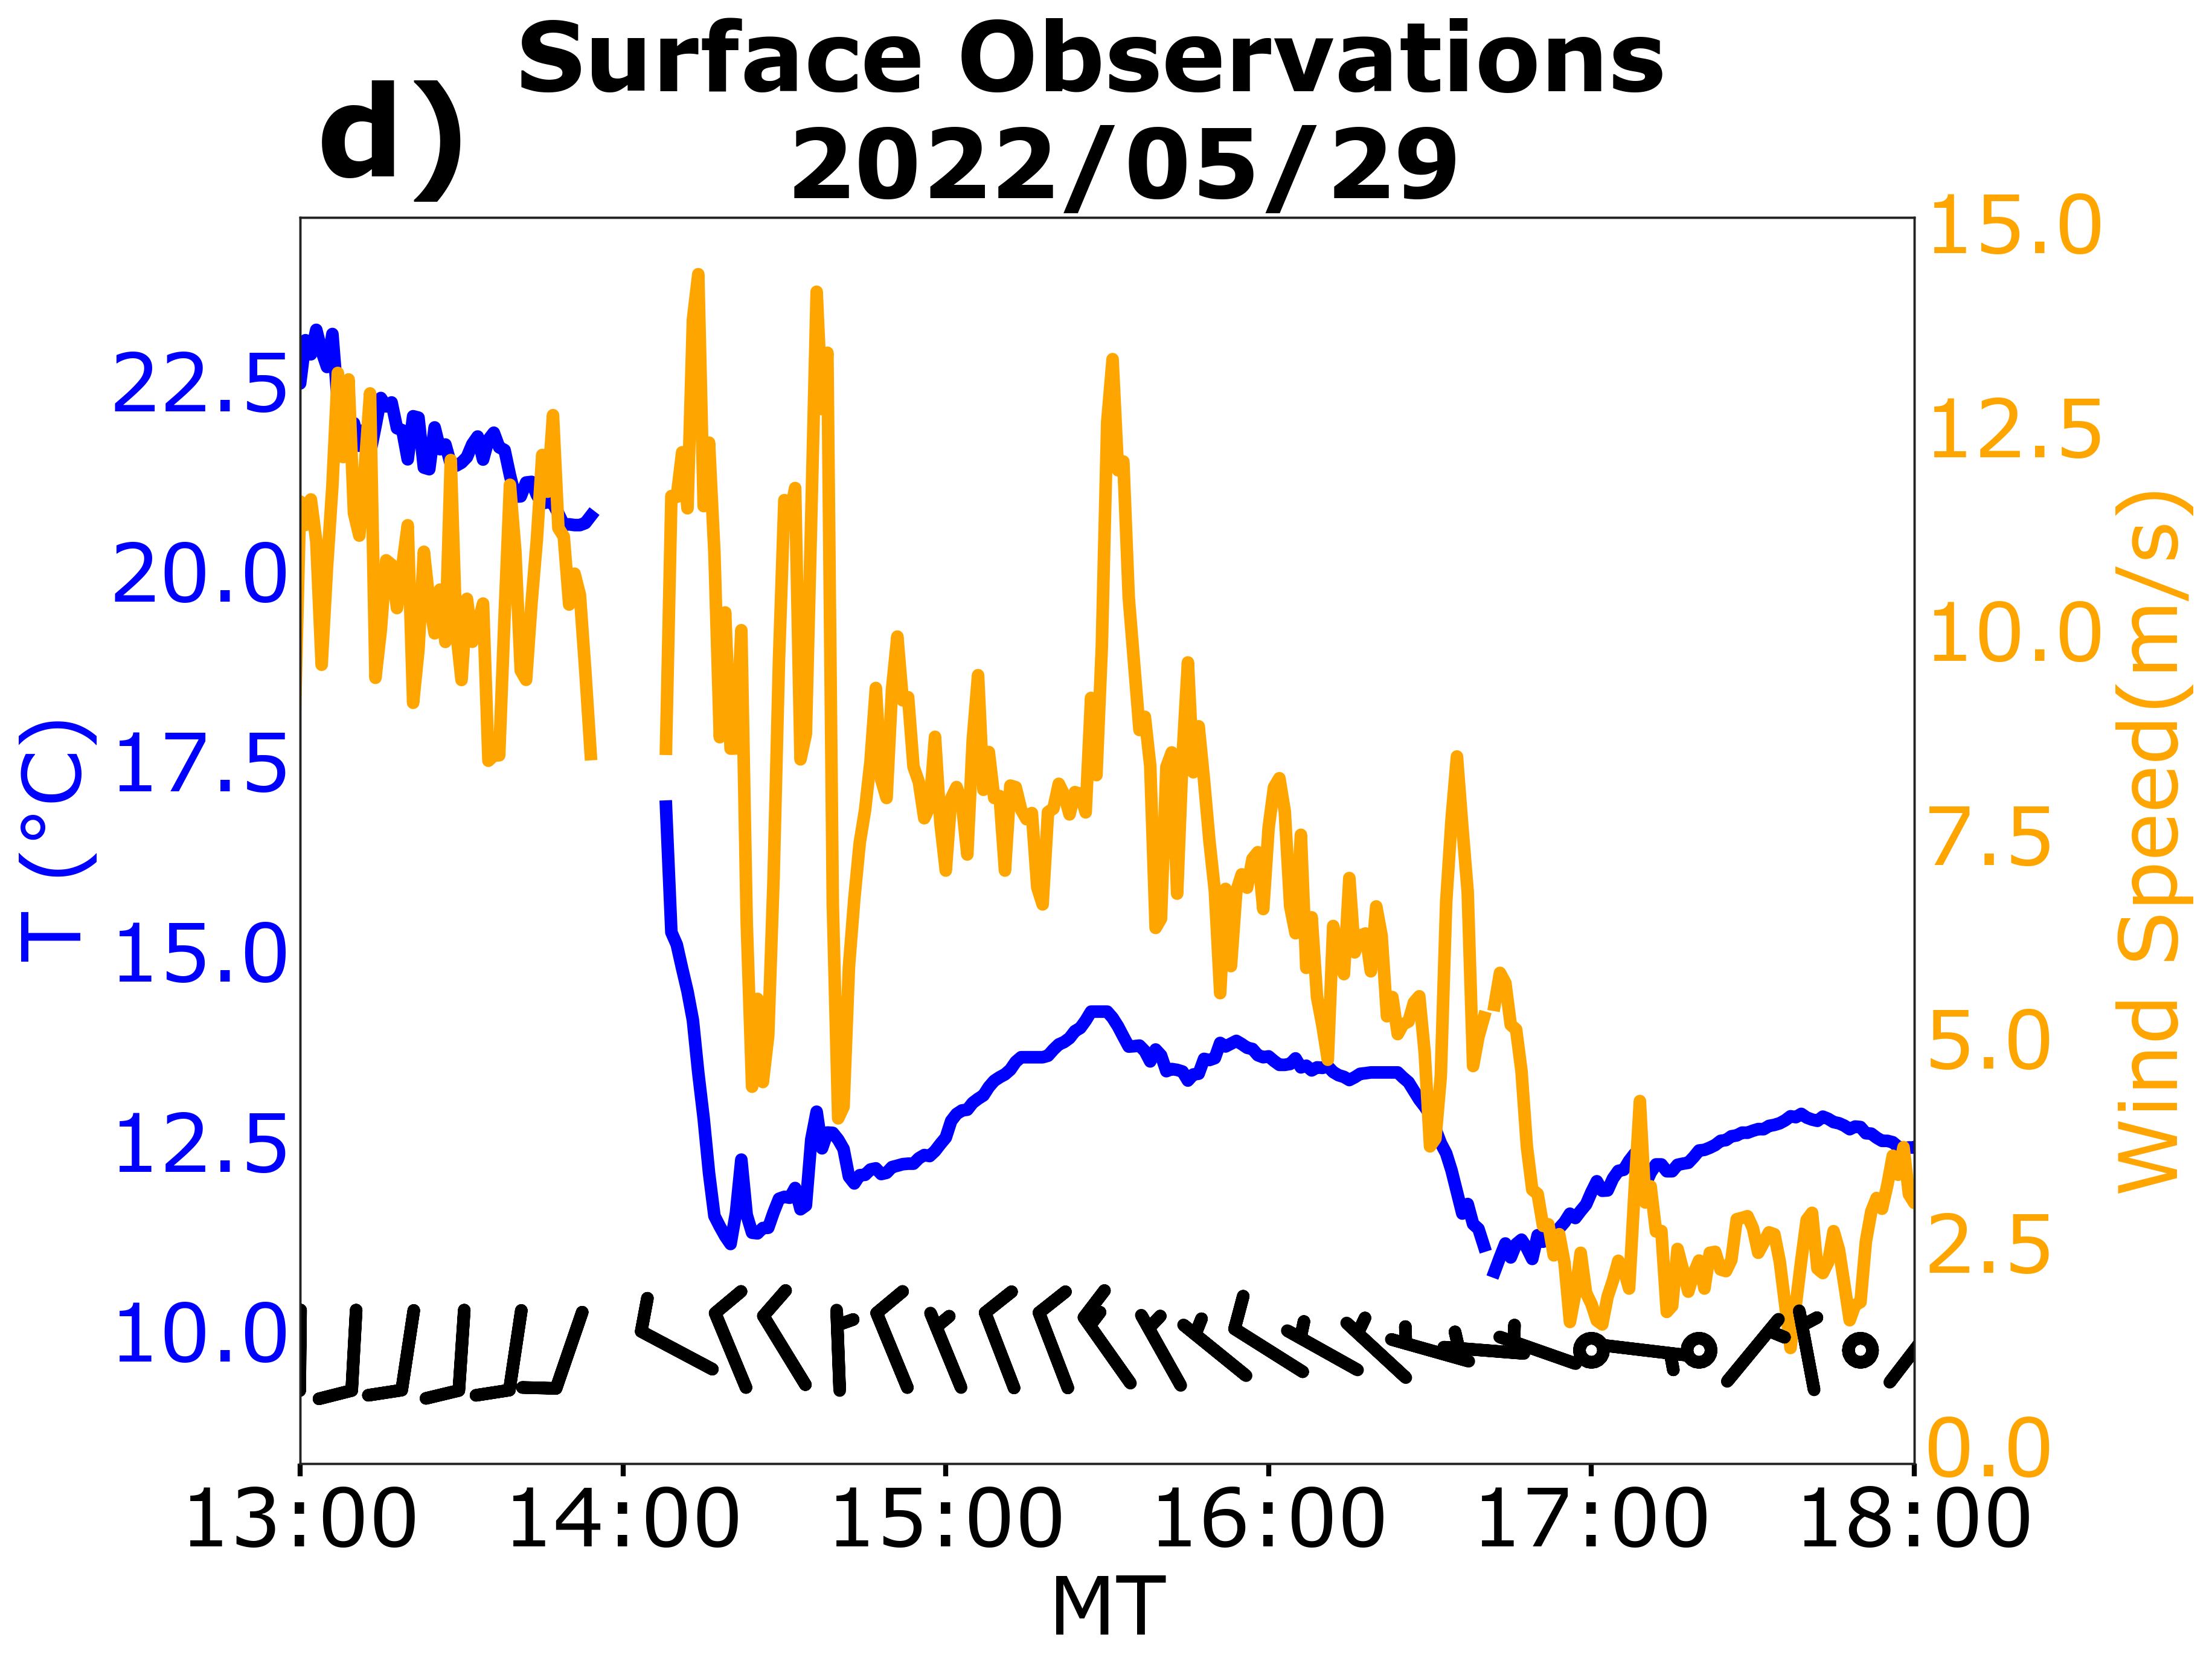

In [145]:
### Plot timeseries of Temperature and wind speed at the surface
case_name_s = 'IOP_03'
FigPath = '/Users/cneumaie/Desktop/Research/CPTrain_1/Figures/'+case_name_s+'_'
fig, ax = plt.subplots(figsize = (13,10))
ax.plot(iop_sfc.index, iop_sfc.temperature, color = 'blue')
ax2 = ax.twinx()
ax2.plot(iop_sfc.index, iop_sfc.wspeed, color = 'orange')

ax.set_ylabel(r'T ($\degree$C)', color = 'blue', fontsize = 32)
ax.tick_params('y',colors ='blue')
ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('orange')
ax2.tick_params('y',colors ='orange')
ax2.set_ylabel(r'Wind Speed(m/s)', fontsize = 32)
ax.set_xlim(datetime.datetime(2022,5,29,13,00), datetime.datetime(2022,5,29,18))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_title("Surface Observations \n 2022/05/29", fontsize = 38, loc = "center" )
ax.text(.01, 1.11, "d)", ha='left', va='top', weight = 'bold', size = 50, transform=ax.transAxes)
ax.set_xlabel('MT', fontsize = 32)
# Create a second axes for the wind barbs
ax3 = ax.twinx()

# Set the y-axis limits of the second axes to be below the first axes
ax3.set_ylim(-2, 20)

# Plot the wind barbs on the second axes
ax3.barbs(iop_sfc.index[::10], np.zeros_like(iop_sfc.index[::10]), iop_sfc.u[::10], iop_sfc.v[::10], 
          length=8, pivot='middle', color='black', linewidth = 5)

# Hide the y-axis of the second axes
ax3.yaxis.set_visible(False)
plt.savefig(FigPath+'CPTrain_Fig1a_v3')
plt.show()
plt.close()